In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm

In [4]:
def generation(n, alpha=1.7, beta=0.9, gamma=10, delta=10):
    # Initialize samples array with zeros
    sample = np.zeros(n)
    
    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    for i in range(n):
        U = np.random.uniform(-np.pi/2, np.pi/2)
        W = -np.log(1 - np.random.uniform(0,1))
        
        # Handle the case alpha = 1 separately
        if alpha != 1:
            part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
            part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
            sample[i] = S_alpha_beta * part1 * part2
        else:
            sample[i] = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U))/(np.pi+beta*U)))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [5]:
default = generation(n=1000)

In [6]:
def gaussian_ker(u=0, y=0, epsilon=1):
    """gaussian kernel for weights
    
    Parameters
    -------------------
    y : float, or array-like
    the point we have, the output

    u : float, or array-like
    the point from which we want to calculate a weight

    epsilon : int, float
    the scale parameter for which we want to compute the kernel
    ----------
    """

    w = (1/np.sqrt(2*np.pi*(epsilon**2)))*np.exp(-(np.abs((u-y)))**2/(2*(epsilon**2)))
    return w

In [7]:
def zolotarev_transfo(sample, xi=0.25):
    """function to use for the estimation based on the zolotarev transformation

    Parameters
    --------------------------
    Sample : array-like
    Sample to do the transformation on

    xi : int, float
    The constant used in the transformation
    --------------------------
    """
    if xi<=0 or xi>1/2 :
        raise ValueError('Xi must be between 0 and 1/2')
    taille = len(sample)
    Z = []
    for i in range(int(taille/3)):
        transfo = sample[3*i-2] - xi*sample[3*i-1] - (1 - xi)*sample[3*i]
        Z.append(transfo)
    V = []
    U = []
    for i in range(len(Z)):
        V.append(np.log(np.abs(Z[i])))
        U.append(np.sign(sample[i]))
    V = np.array(V)
    U = np.array(U)
    S_U_squared = (np.std(U))**2
    S_V_squared = (np.std(V))**2
    nu_tilde = (6/(np.pi)**2)*S_V_squared - (3/2)*S_U_squared + 1
    etha_hat = np.mean(U)
    tau_hat = np.mean(V)
    nu_hat = 0
    if nu_tilde > ((1+np.abs(etha_hat))**2)/4:
        nu_hat = nu_tilde
    else:
        nu_hat = ((1+np.abs(etha_hat))**2)/4
    delta_hat = np.mean(sample)
    S_2 = np.array((nu_hat, etha_hat, tau_hat, delta_hat))
    return S_2

In [8]:
zolo_y = np.zeros((1000, 4))

for i in range(1000):    
    y = generation(1000)
    zolo_y[i] = zolotarev_transfo(sample=y)

varcov = np.cov(m=zolo_y, rowvar=False)

In [9]:
def pi_lf(epsilon_t, sample=default, N=1000, alpha=1.7, beta=0.9, gamma=10, delta=10, possession=False):
    """function to have the likelihood free density given in the article

    Parameters
    -----------------
    N : int
    number of priors we want to generate
        
    alpha, beta, gamma, delta : int, float
    the parameters with which we want to compute the true data if we don't already have it


    sample : array-like
    the data we observe

    summary_statistic : array-like
    summary statistic used to make tests on the distance between two datasets

    epsilon_t : int, float
    scale parameter, determines 

    Possession : boolean
    by default, set to false, to determine if we want to generate the data or if we already have it

    method : str
    the method with which we would compute the summary statistics
    -------------------
    """
    if possession == False :
        data = generation(n=1000, alpha=alpha, beta=beta, gamma=gamma, delta=delta)
    else :
        data = sample
    #set the priors like in the paper
    prior_alpha = np.random.uniform(1.1, 2., size=N)
    prior_beta = np.random.uniform(-1., 1, size=N)
    prior_gamma = np.random.uniform(0., 300., size=N)
    prior_delta = np.random.uniform(-300., 300., size=N)
    prior_gen = np.vstack((prior_alpha,prior_beta,prior_gamma, prior_delta))
    prior_gen = np.transpose(prior_gen)
    true_param = zolotarev_transfo(sample=data)

    
    
    proposed_param = np.zeros((N,4))
    for i in range(N):
        proposed_data = generation(n=N, alpha=prior_gen[i,0], beta=prior_gen[i,1],
                                  gamma=prior_gen[i,2], delta=prior_gen[i,3])
        proposed_param[i] = zolotarev_transfo(sample=proposed_data)

    diff = np.zeros((N,4))   
    for i in range(N):
        diff[i] = proposed_param[i]-np.random.multivariate_normal(mean=true_param, cov=varcov, size=1)
    kernel_applied = gaussian_ker(u=diff, y=0, epsilon=epsilon_t)/epsilon_t

    
    pi_lf_output = np.zeros((N, 4))
    for i in range(N):
        pi_lf_output[i] = prior_gen[i]*kernel_applied[i]
    
    return pi_lf_output, kernel_applied
    

In [10]:
test_1 = pi_lf(epsilon_t=0.5)[0]

In [11]:
np.mean(test_1[:,0])

1.6467783662192461

In [12]:
np.mean(test_1[:,1])

-0.06349089365232974

In [13]:
np.mean(test_1[:,2])

0.7495613245664506

In [14]:
np.mean(test_1[:,3])

0.10733644413997621

# ABC accept reject

In [15]:
donnees = generation(n=1000)

In [69]:
nb_prior = 1000
epsilon_ar = 1.5

In [17]:
prior_alpha_ar = np.random.uniform(1.1, 2., size=nb_prior)
prior_beta_ar = np.random.uniform(-1., 1, size=nb_prior)
prior_gamma_ar = np.random.uniform(0., 300., size=nb_prior)
prior_delta_ar = np.random.uniform(-300., 300., size=nb_prior)
prior_gen_ar = np.vstack((prior_alpha_ar,prior_beta_ar,prior_gamma_ar, prior_delta_ar))
prior_gen_ar = np.transpose(prior_gen_ar)

In [18]:
zolo_aimed = zolotarev_transfo(sample=donnees)

In [19]:
zolo_proposal = np.zeros((nb_prior, 4))
param_accepted = np.zeros(4)
for i in range(nb_prior):
    proposal = generation(n=1000, alpha=prior_gen_ar[i,0],
                          beta=prior_gen_ar[i,1], gamma=prior_gen_ar[i,2], delta=prior_gen_ar[i,3])
    zolo_proposal[i] = zolotarev_transfo(sample=proposal)
    if np.linalg.norm(zolo_aimed - zolo_proposal[i])<epsilon_ar:
        param_accepted = np.vstack((param_accepted,prior_gen_ar[i]))

        
        

In [20]:
test_8 = generation(n=10000)
test_9 = generation(n=10000, alpha = 1.8, beta=0.8, gamma=8, delta=9)
zolo_8 = zolotarev_transfo(test_8)
zolo_9 = zolotarev_transfo(test_9)
np.linalg.norm(zolo_8-zolo_9)

0.828450652531212

In [21]:
param_accepted.shape

(4,)

Très petite acceptance rate

In [22]:
param_accepted = np.delete(arr=param_accepted, obj=0, axis=0)

In [23]:
np.mean((param_accepted[:,0]))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [24]:
np.mean((param_accepted[:,1]))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [25]:
np.mean((param_accepted[:,2]))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [26]:
np.mean((param_accepted[:,3]))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [27]:

mille = np.linspace(start=100, stop=1000, endpoint=True, num=10)[::-1]
cent = np.linspace(start=10, stop=100, endpoint=False, num=90)[::-1]
dix = np.linspace(start=5, stop=10, endpoint=False, num=10)[::-1]
cinq = np.linspace(start=3, stop=5, endpoint=False, num=40)[::-1]
trois = np.linspace(start=0, stop=3, endpoint=False, num=300)
trois = np.delete(arr=trois, obj=0)
trois = trois[::-1]

scale_param = np.concatenate((mille, cent, dix, cinq, trois))


In [77]:
nb_prior = 5000

In [78]:
prior_alpha_ar = np.random.uniform(1.1, 2., size=nb_prior)
prior_beta_ar = np.random.uniform(-1., 1, size=nb_prior)
prior_gamma_ar = np.random.uniform(0., 300., size=nb_prior)
prior_delta_ar = np.random.uniform(-300., 300., size=nb_prior)
prior_gen_ar = np.vstack((prior_alpha_ar,prior_beta_ar,prior_gamma_ar, prior_delta_ar))
prior_gen_ar = np.transpose(prior_gen_ar)

In [79]:
matrix_gen = np.zeros((nb_prior,4))
for i in tqdm(range(nb_prior)):
    proposal = generation(n=100000, alpha=prior_gen_ar[i,0],
                          beta=prior_gen_ar[i,1], gamma=prior_gen_ar[i,2], delta=prior_gen_ar[i,3])
    zolo_proposal = zolotarev_transfo(sample=proposal)
    matrix_gen[i] = zolo_proposal

  2%|▏         | 93/5000 [00:49<43:16,  1.89it/s] 


KeyboardInterrupt: 

In [67]:
matrix_gen

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
parametres_epsilon = np.zeros((449,4))
for j in tqdm(range(449)):
    param_accepted = np.zeros(4)
    for i in range(100000):
        if np.linalg.norm(zolo_aimed - matrix_gen[i])<scale_param[j]:
            param_accepted = np.vstack((param_accepted,prior_gen_ar[i]))
    param_accepted = np.delete(arr=param_accepted, obj=0, axis=0)
    param_accepted_i = np.mean(param_accepted, axis=0)
    parametres_epsilon[j] = param_accepted_i




  0%|          | 0/449 [00:00<?, ?it/s]


IndexError: index 1000 is out of bounds for axis 0 with size 1000

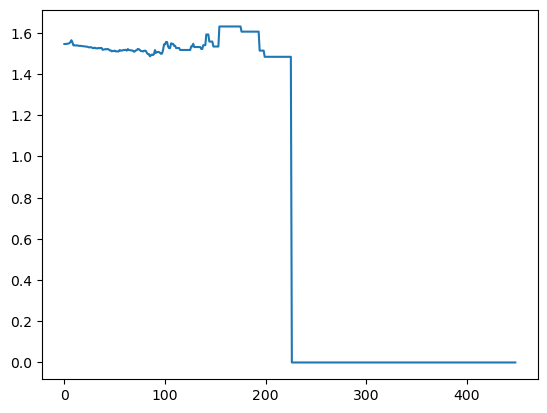

In [50]:
plt.plot(parametres_epsilon[:,0])
plt.show()

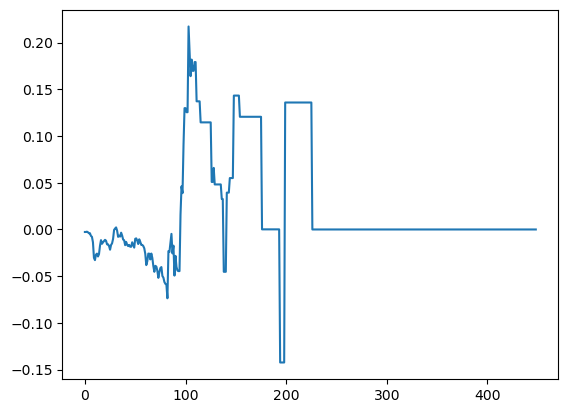

In [51]:
plt.plot(parametres_epsilon[:,1])
plt.show()

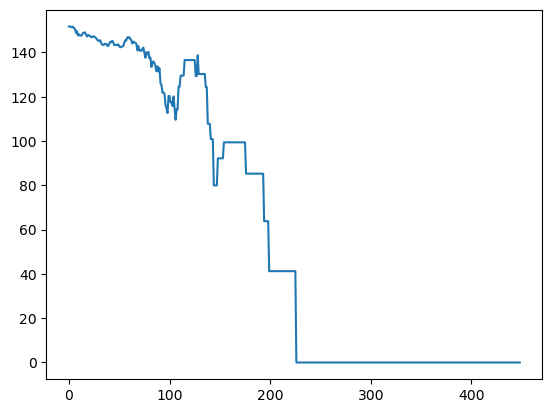

In [58]:
plt.plot(parametres_epsilon[:,2])
plt.show()

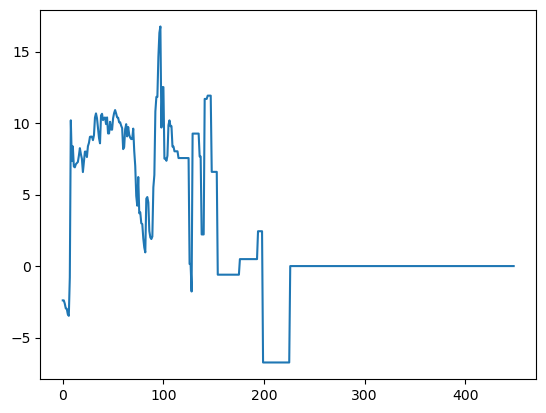

In [59]:
plt.plot(parametres_epsilon[:,3])
plt.show()

In [55]:
truc.shape

(449,)